In [2]:
# Import necessary libraries for what's ahead

import math
import tensorflow as tf
import random
import scipy
import numpy as np
import numpy.matlib
from matplotlib import cm
import scipy.spatial.distance as scidist

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as ani
%matplotlib notebook  

from mpl_toolkits.mplot3d import Axes3D

In [109]:
input_size = 1
output_size = 2

hidden_layers = [10,10]

foo = lambda x: (((x[0]) * 2 ) % 2) - 1
get_xs = lambda size: [[np.random.uniform(-1,1)]*input_size for _ in range(size)]
get_ys = lambda xs: [[int(foo(_in) > 0), int(foo(_in) <= 0)] for _in in xs]



For smaller networks try larger learning rates and smaller batch sizes. For larger networks try smaller learning rates and bigger batch sizes.

For example, in classifying a circle with 2 hidden layers of size 10, we reached 99% accuracy with a learning rate of 0.05 and a batch size of 100. For a network with 5 hidden layers of size 10 we had to drop the learning rate to 0.001 and raise the batch size to 1000 to achieve the same accuracy

In [ ]:
b = {}
w = {}
s = {}
t = {}
do = {}

keep_prob = tf.placeholder(tf.float32)
x = tf.placeholder(tf.float32, [None, input_size])
t[-1] = x
n_last = input_size
for l in range(len(hidden_layers)):
    w[l] = tf.Variable(tf.random_uniform([n_last, hidden_layers[l]]))    
    b[l] = tf.random_uniform([hidden_layers[l]])
    do[l] = tf.nn.dropout(t[l-1], keep_prob)
    s[l] = tf.add(tf.matmul(do[l], w[l]), b[l])
    t[l] = tf.nn.relu(s[l])
    n_last = hidden_layers[l]

w[l+1] = tf.Variable(tf.random_uniform([n_last, output_size]))  
y = tf.matmul(t[l], w[l+1])

y_ = tf.placeholder(tf.float32, [None, output_size]) #true output
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))

train_step = tf.train.GradientDescentOptimizer(0.1).minimize(cross_entropy)




batch_size = 100


correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


print "Beginning session"
sess = tf.InteractiveSession()

print "initializing variables"
tf.global_variables_initializer().run()
# Train
mi_XTs = []
mi_YTs = []
trial = 0

while True:
    if trial % 10000 == 0:
        test_xs = [[i] for i in np.linspace(-1,1,num = 100)]
        test_ys = get_ys(test_xs)
        print "Trial %d: %.3f" %(trial, accuracy.eval(feed_dict={x: test_xs, y_: test_ys, keep_prob: 1}))
        #print "\t \t", [tf.reduce_max(w.values()[i]).eval() for i in range(len(w))]
        for layer in t:
            layer_t = t[layer].eval(feed_dict={x:test_xs, keep_prob:1})
            print "\t", layer, "-",binned_entropy(layer_t, 32)
            print "\t\t",binned_entropy([layer_t[i] for i in range(len(layer_t)) if test_ys[i][0] == 0], 32)
            print "\t\t",binned_entropy([layer_t[i] for i in range(len(layer_t)) if test_ys[i][0] == 1], 32)                        
        
    
    batch_xs = get_xs(batch_size)
    batch_ys = get_ys(batch_xs)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.9})

        # I(X;Ti) = H(Ti)
        # I(Ti;Y) = H(Ti) - H(Ti|Y)

        #mi_XT, mi_YT = mutual_info(test_xs, test_ys)
        #mi_YTs.append(mi_YT)        
    
    trial += 1
    
    

Beginning session
initializing variables
Trial 0: 0.510
	0 - 4.90558812981
		3.84382963675
		4.40482795605
	1 - 4.92493881415
		3.87215990024
		4.42023382344
	-1 - 4.99248768917
		4.05343661589
		4.42023382344


In [107]:
norm = lambda ls: np.array(ls)/sum(ls)
entropy = lambda ps: -sum([p * np.log2(p) for p in ps if p > 0])

def binned_entropy(pts, num_bins):
    ''' 
    Inputs: t
    '''
    diffs = [scidist.euclidean(pts[i], pts[i+1]) for i in range(len(pts) - 1)]
    #print diffs[:10]
    bin_size = sum(diffs)/ float(num_bins)
    idx = 0
    pts_along = 0
    bins = np.zeros(shape = num_bins)
    bins[0] += 1
    
    for bin in range(num_bins):
        while pts_along + diffs[idx] <= (bin + 1) * bin_size:
            pts_along += diffs[idx]
            bins[bin] += 1
            idx += 1
            if idx >= len(diffs):
                
                return entropy(norm(bins))
            
    return entropy(bins)


In [99]:
for layer in t:
    layer_t = t[layer].eval(feed_dict={x:test_xs, keep_prob:1})
    print layer_t[:10]
    print "\t", layer, "-",binned_entropy(layer_t, 2)
    #print "\t\t",binned_entropy([layer_t[i] for i in range(len(layer_t)) if test_ys[i][0] == 0], 32)
    #print "\t\t",binned_entropy([layer_t[i] for i in range(len(layer_t)) if test_ys[i][0] == 1], 32)   

[[ 1.05407691  1.53741145  1.49801135  0.47466105  1.25780296]
 [ 0.01893914  0.          0.1928767   0.          0.39857751]
 [ 0.30737936  0.20524079  0.55655134  0.          0.63799995]
 [ 1.06235313  1.55217719  1.50844646  0.48110062  1.26467276]
 [ 0.76796961  1.02697229  1.13727832  0.2520498   1.02031708]
 [ 0.32839474  0.24273396  0.58304816  0.          0.65544391]
 [ 0.39156103  0.35542789  0.66269022  0.          0.70787567]
 [ 0.92438972  1.30603874  1.33449769  0.37375543  1.15015495]
 [ 0.          0.          0.16212416  0.          0.37833181]
 [ 1.08496785  1.59252357  1.53695977  0.49869639  1.28344429]]
	0 - [2.4702413082122803, 0.5611630082130432, 1.9785106182098389, 0.7825864553451538, 1.145464301109314, 0.1605672836303711, 1.40506112575531, 2.161040782928467, 2.582902669906616, 1.9983893632888794]
51.0
0.999711441753
[[ 2.04822779  4.24020386  0.          0.          0.        ]
 [ 0.58544356  0.9103238   0.          0.16299713  0.        ]
 [ 0.89949226  1.48255

<IPython.core.display.Javascript object>


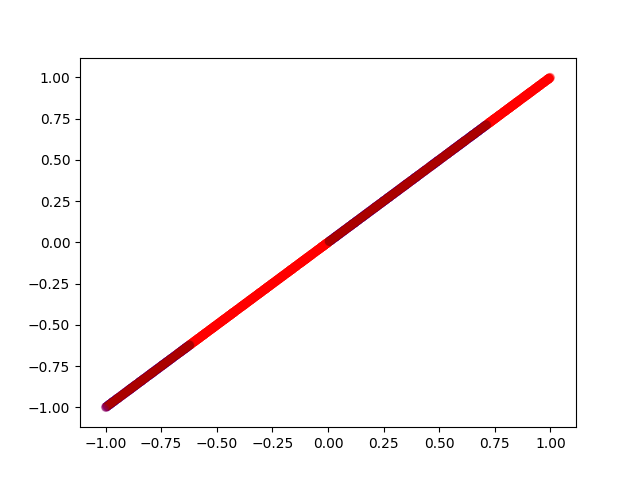

In [32]:
%matplotlib notebook
fig = plt.figure()

In [87]:
xs = get_xs(10000)
ys_ = get_ys(xs)
ys = y.eval(feed_dict={x: xs, keep_prob: 1})
colors = [['red', 'blue'][out[0] < out[1]] for out in ys]

xs_zip = zip(*xs)

ax = fig.add_subplot(111)
ax.scatter(xs_zip[0], xs_zip[0], c=colors, alpha = 0.01)

In [89]:
np.max(0,1)

ValueError: 'axis' entry is out of bounds

In [4]:
norm = lambda ns: [float(n)/sum(ns) for n in ns]
entropy = lambda ps: -sum([p*np.log2(p) for p in ps if p > 0])

# I(X;Ti) = H(Ti)
# I(Ti;Y) = H(Ti) - H(Ti|Y)

def H_Ti(i, test_xs, bins = 30):
    ti = t[i].eval(feed_dict = {x:test_xs}).T
    ti.transpose
    max_val =  
    
    for i in range(len(ti))
    if max_val == min_val:
        return 0
    
    hist = tf.histogram_fixed_width(ti, [min_val, max_val], nbins = bins).eval()
    #print hist
    #print norm(hist)
    return entropy(norm(hist))
    
def H_given_Y(i, test_xs, test_ys, bins = 30):
    test_size = len(test_xs)
    H = 0
    for hot in range(output_size):
            xs_hot = [test_xs[j] for j in range(len(test_xs)) if test_ys[j][hot] == 1]
            H += (float(len(xs_hot))/test_size) * H_Ti(i, xs_hot)
    return H
        

SyntaxError: invalid syntax (<ipython-input-4-a023c90b8104>, line 10)

In [100]:
range(-1,1, 0.1)

TypeError: range() integer step argument expected, got float.